In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from scipy import stats

# Filter analysis

In this notebook, we analyze all `logsBloom` filters contained in the first 15 million blocks of the Ethereum blockchain.

For each block, we store the corresponding timestamp, the number of bits set to 1 in the filter (`numOnes`) and the ratio between `numOnes` and total number of bits `numBits` (i.e., 2048).

In [2]:
numBits = 2048
filters_ones = pd.read_csv('data/filters_ones_0-14999999.csv.xz', compression='xz', header=None)
filters_ones.columns = ['blockId', 'timestamp', 'numOnes']
filters_ones['ratio'] = filters_ones['numOnes'] / 2048
filters_ones['timestamp'] = filters_ones['timestamp'].astype('datetime64[s]')
filters_ones.head()

,blockId,timestamp,numOnes,ratio
0,0,1970-01-01 00:00:00,0,0.0
1,1,2015-07-30 15:26:28,0,0.0
2,2,2015-07-30 15:26:57,0,0.0
3,3,2015-07-30 15:27:28,0,0.0
4,4,2015-07-30 15:27:57,0,0.0


We print some basic statistics (i.e., average number of ones, standard deviation and average ratio).

In [4]:
print('Avg. number of ones\t: {}\nStd. deviation\t\t: {}'.format(filters_ones.numOnes.mean(),filters_ones.numOnes.std()))
print('Avg. ratio\t\t: {}'.format(filters_ones.ratio.mean()))

Avg. number of ones	: 417.7440142666667
Std. deviation		: 371.3960266976995
Avg. ratio		: 0.20397656946614584


Then we plot the distribution of the number of bits set to 1.

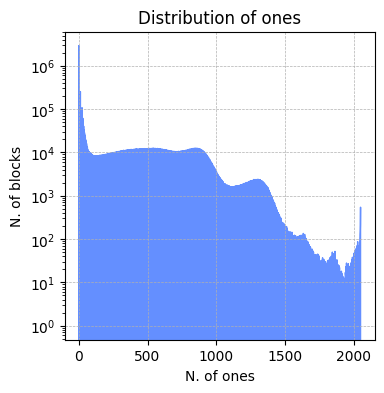

In [9]:
domain = np.arange(0, numBits + 1)
data = filters_ones.numOnes.value_counts().reindex(domain, fill_value=0)
binWidth = 10
histBins = range(0, filters_ones.numOnes.max() + binWidth, binWidth)
plt.figure(figsize=(4, 4))
plt.title('Distribution of ones')
plt.xlabel('N. of ones')
plt.ylabel('N. of blocks')
#plt.xscale('log')
plt.yscale('log')
#plt.hist(filters_ones.numOnes, bins=histBins, color='#648fff')
plt.fill_between(data.index.values, data.values, color='#648fff')
#plt.scatter(data.index.values, data.values, color='#648fff', marker='.')
plt.grid(linestyle='--', linewidth=0.5)
plt.savefig("pictures/dist_ones.pdf", format='pdf', bbox_inches='tight')
plt.show()

Now we compute the average number of ones and ratio for each year.

In [8]:
x = filters_ones.groupby([filters_ones.timestamp.dt.year]).mean('numOnes').drop(['blockId'], axis=1)
x.drop(index=x.index[0], axis=0, inplace=True)
x.reset_index()

,timestamp,numOnes,ratio
0,2015,0.914518,0.000447
1,2016,6.727867,0.003285
2,2017,111.158306,0.054277
3,2018,362.787394,0.177142
4,2019,447.308092,0.218412
5,2020,632.564766,0.308870
6,2021,805.251780,0.393189
7,2022,808.040508,0.394551


The plot below presents a more detailed insight of the average number of ones during each year. 

In the histogram, each bin corresponds to 1 month.

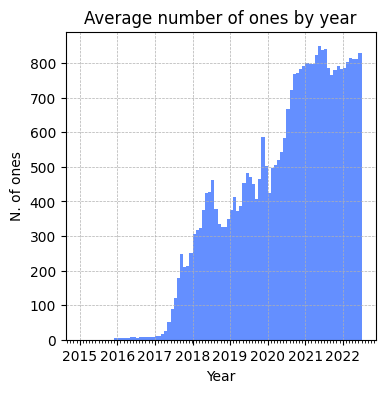

In [13]:
d1 = filters_ones.timestamp.astype(int).floordiv(10**9).values
d2 = filters_ones.numOnes.values
histBins = [pd.Timestamp(y, m, 1).timestamp() for y in range(2015, 2023, 1) for m in range(1, 12+1, 1)]
plotBins = [datetime.datetime(y, m, 1) for y in range(2015, 2023, 1) for m in range(1, 12+1, 1)]
s = stats.binned_statistic(d1, d2, statistic='mean', bins=histBins)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.set_title('Average number of ones by year')
ax.set_xlabel('Year')
ax.set_ylabel('N. of ones')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.stairs(s.statistic[:-1], plotBins[:-1], color='#648fff', fill=True)
ax.grid(linestyle='--', linewidth=0.5)
plt.savefig("pictures/temporal_ones.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Receipt analysis

In this section we conduct an analysis of the TX receipts for all blocks in our data set.

In [7]:
receipts = pd.read_csv('data/receipt_stats_0-14999999.csv.xz', compression='xz', header=None)
receipts.columns = ['blockId', 'txCount', 'numLogs', 'numKeys', 'numUniqueKeys']
receipts['timestamp'] = filters_ones['timestamp'].values
#receipts['fprAll'] = np.power(1 - np.exp(-(3 * receipts['numKeys'])/2048), 3)
receipts['fpr'] = np.power(1 - np.exp(-(3 * receipts['numUniqueKeys'])/2048), 3)
receipts.head()

,blockId,txCount,numLogs,numKeys,numUniqueKeys,timestamp,fpr
0,0,0,0,0,0,1970-01-01 00:00:00,0.0
1,1,0,0,0,0,2015-07-30 15:26:28,0.0
2,2,0,0,0,0,2015-07-30 15:26:57,0.0
3,3,0,0,0,0,2015-07-30 15:27:28,0.0
4,4,0,0,0,0,2015-07-30 15:27:57,0.0


We first print some basic statistics about all blocks.
For each block, we are interested in the following attributes.

1. the number of transactions included in the block;
2. the number of keys (i.e., contract addresses and log topics) inserted in the filter;
3. the number of unique (i.e., distinct) keys;
4. the false positive rate $p$ of the filter, which is computed as follows:

In [7]:
data = [
    ['Transactions', receipts.txCount.mean(), receipts.txCount.std()],
    #['Logs', receipts.numLogs.mean(), receipts.numLogs.std()],
    ['Keys', receipts.numKeys.mean(), receipts.numKeys.std()],
    ['Unique keys', receipts.numUniqueKeys.mean(), receipts.numUniqueKeys.std()],
    ['FPR', receipts.fpr.mean(), receipts.fpr.std()]
]
basic_receipt_stats = pd.DataFrame(data, columns=['Attribute', 'Average', 'Std. deviation'])#.set_index('Attribute')
basic_receipt_stats

,Attribute,Average,Std. deviation
0,Transactions,107.577962,101.440702
1,Keys,513.159945,641.257230
2,Unique keys,177.330260,188.956036
3,FPR,0.031844,0.059950


The next plot represents the distribution of the number of unique keys.

Note that each bin of the histogram has a width of 100 keys.


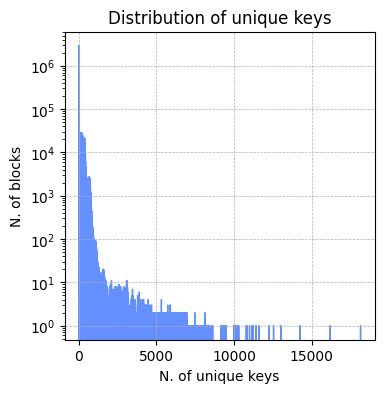

In [11]:
maxKeys = np.max(receipts.numUniqueKeys)
domain = np.arange(0, maxKeys + 1)
data = receipts.numUniqueKeys.value_counts().reindex(domain, fill_value=0)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.set_title('Distribution of unique keys')
ax.set_xlabel('N. of unique keys')
ax.set_ylabel('N. of blocks')
ax.set_yscale('log')
#ax.hist(receipts.numUniqueKeys, bins=histBins, color='#648fff')
ax.fill_between(data.index.values, data.values, color='#648fff')
ax.grid(linestyle='--', linewidth=0.5)
plt.savefig("pictures/dist_keys.pdf", format='pdf', bbox_inches='tight')
plt.show()

We now show how the number of unique keys has evolved over time.

Each bin represents one month in the time period between 2015 and 2023.

For each month, we count the average number of keys for all blocks mined during that month.

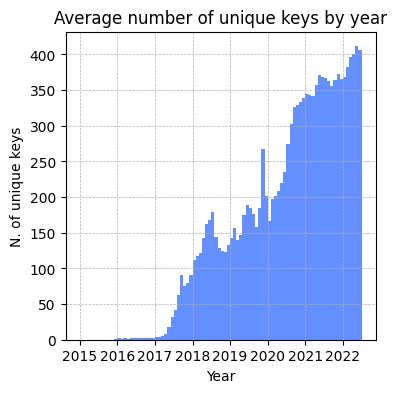

In [12]:
d1 = receipts.timestamp.astype(int).floordiv(10**9).values
d2 = receipts.numUniqueKeys.values
histBins = [pd.Timestamp(y, m, 1).timestamp() for y in range(2015, 2023, 1) for m in range(1, 12+1, 1)]
plotBins = [datetime.datetime(y, m, 1) for y in range(2015, 2023, 1) for m in range(1, 12+1, 1)]
s = stats.binned_statistic(d1, d2, statistic='mean', bins=histBins)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.set_title('Average number of unique keys by year')
ax.set_xlabel('Year')
ax.set_ylabel('N. of unique keys')
ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_minor_locator(AutoMinorLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.stairs(s.statistic[:-1], plotBins[:-1], color='#648fff', fill=True)
ax.grid(linestyle='--', linewidth=0.5)
plt.savefig("pictures/temporal_keys.pdf", format='pdf', bbox_inches='tight')
plt.show()